In [1]:
import torch
import numpy as np
import argparse
import json
import os
from importlib import import_module
import pandas as pd
import matplotlib.pyplot as plt 

import albumentations as A
from albumentations.pytorch import ToTensorV2

from augmentation import BasicAugmentation
from model import DeepLabV3Plus_resnext101_32x8d
from utils import get_category_names
from load_data import CustomDataLoader

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = DeepLabV3Plus_resnext101_32x8d(num_classes=12).to(device)

# load test_loader
dataset_path = '../data'
test_path = dataset_path + '/test.json'

model_name = 'DeepLabV3Plus_resnext101_32x8d'
model_num = ''
type = 'mIoU'

# best model 저장된 경로
model_path = os.path.join('./results', f"{model_name}{model_num}", f"{model_name}_best_{type}.pt")
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

category_names = get_category_names(dataset)

def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = CustomDataLoader(dataset_path=dataset_path, data_dir=test_path, category_names=category_names, mode='test')

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=5,
                                        num_workers=4,
                                        collate_fn=collate_fn
                                        )

size = 256
transform = A.Compose([A.Resize(256, 256)])
aug_transform = [A.Compose([]), A.Compose([A.HorizontalFlip(1.0)]), A.Compose([A.VerticalFlip(1.0)])]
print('Start prediction.')
model.eval()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Start prediction.


2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
        (2): Bottleneck(
          (conv1): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
        (3): Bottleneck(
          (conv1): C

In [3]:
def softmax(x, axis):
    maximum = np.max(x,axis=axis,keepdims=True) #returns max of each row and keeps same dims
    e_x = np.exp(x - maximum) #subtracts each row with its max value
    summation = np.sum(e_x,axis=axis,keepdims=True) #returns sum of each row and keeps same dims
    f_x = e_x / summation 
    return f_x

In [12]:
mask_list = []
imgs_list = []
imgs_trans = []
with torch.no_grad():
    raw_imgs, image_infos = next(iter(test_loader))
    for trans in aug_transform:
        imgs = []
        for img in raw_imgs:
            print(img.shape)
            img = trans(image=img)['image']
            imgs.append(img)
        imgs = np.stack(imgs)
        print(imgs.shape)
        imgs_trans.append(imgs)

        # inference (512 x 512)
        outs = model(torch.from_numpy(imgs).to(device))
        oms = outs.squeeze().detach().cpu().numpy()

        
        # resize (256 x 256)
        temp_mask = []
        temp_img = []
        for img, mask in zip(np.stack(imgs), oms):
            mask = np.transpose(mask, [1,2,0])
            img = np.transpose(img, [1,2,0])
            transformed = transform(image=img, mask=mask)
            mask = np.transpose(transformed['mask'], [2,0,1])
            img = np.transpose(transformed['image'], [2,0,1])
            temp_mask.append(mask)
            temp_img.append(img)

        oms = np.array(temp_mask, dtype=np.float16)
        oms = trans(image=img, mask=oms)['mask']
        
        oms = oms.reshape([oms.shape[0], 12, size*size])
        oms = softmax(oms, axis=1)

        imgs_list.append(temp_img)
        mask_list.append(oms)


(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(5, 3, 512, 512)


TypeError: max() received an invalid combination of arguments - got (keepdims=bool, axis=int, out=NoneType, ), but expected one of:
 * ()
 * (name dim, bool keepdim)
 * (Tensor other)
 * (int dim, bool keepdim)


3
(3, 512, 512)


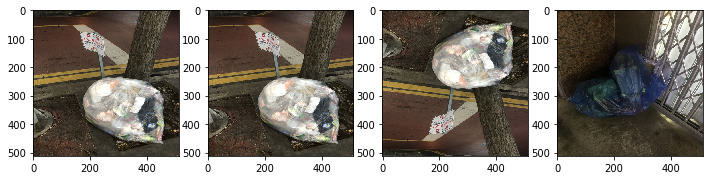

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))

idx = 0

print(len(imgs_trans))
print(raw_imgs[idx].shape)

ax1.imshow(raw_imgs[idx].transpose([1,2,0]))
ax2.imshow(imgs_trans[0][idx].transpose([1,2,0]))
ax3.imshow(imgs_trans[1][idx].transpose([1,2,0]))
ax4.imshow(imgs_trans[2][idx+1].transpose([1,2,0]))

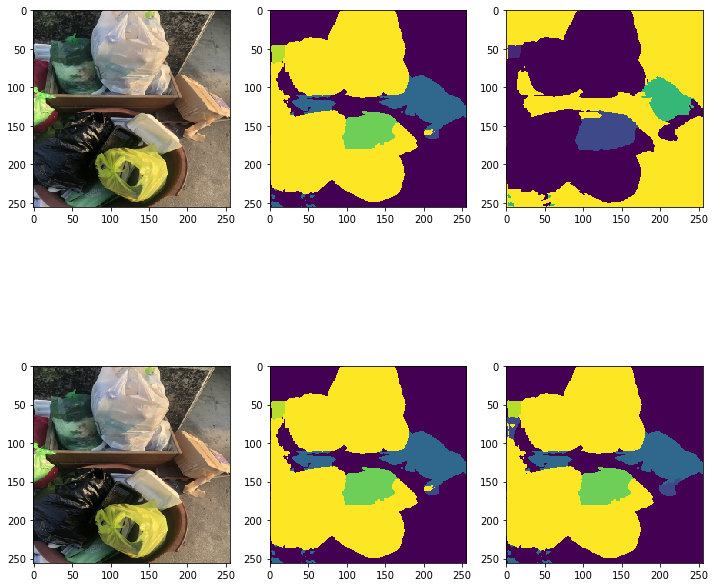

[0 2 3 7 8 9]
[ 2  3  4  8 11]
[0 2 3 7 8 9]
[0 2 3 7 8 9]


In [6]:
COLORS = [
    [129 / 255, 236 / 255, 236 / 255],
    [2 / 255, 132 / 255, 227 / 255],
    [232 / 255, 67 / 255, 147 / 255],
    [255 / 255, 234 / 255, 267 / 255],
    [0 / 255, 184 / 255, 148 / 255],
    [85 / 255, 239 / 255, 196 / 255],
    [48 / 255, 51 / 255, 107 / 255],
    [255 / 255, 159 / 255, 26 / 255],
    [255 / 255, 204 / 255, 204 / 255],
    [179 / 255, 57 / 255, 57 / 255],
    [248 / 255, 243 / 255, 212 / 255],
]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(12, 12))

# output1 = ((imgs_list[0][idx]) + (0.05 * np.argmax(mask_list[0][idx], axis=0).reshape(-1, 256, 256))).transpose([1,2,0])
# output2 = ((imgs_list[0][idx]) + (0.05 * np.argmax(mask_list[1][idx], axis=0).reshape(-1, 256, 256))).transpose([1,2,0])

mask1 = np.argmax(mask_list[0][idx], axis=0).reshape(256, 256)
mask2 = np.argmax(mask_list[1][idx], axis=0).reshape(256, 256)
mask3 = np.argmax(mask_list[2][idx], axis=0).reshape(256, 256)
mask4 = np.argmax(mask_list[0][idx] + mask_list[1][idx] + mask_list[2][idx], axis=0).reshape(256, 256)

# ax1.imshow(np.clip(output1, 0., 1.))
# print(np.max(output2), np.min(output2))
ax1.imshow(imgs_list[0][idx].transpose([1,2,0]))
ax2.imshow(mask1)
ax3.imshow(mask2)
ax4.imshow(imgs_list[0][idx].transpose([1,2,0]))
ax5.imshow(mask3)
ax6.imshow(mask4)
# ax2.imshow(np.clip(output2, 0., 1.))

plt.show()
print(np.unique(mask1))
print(np.unique(mask2))
print(np.unique(mask3))
print(np.unique(mask4))

In [7]:
print(mask3)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 3 3 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 [0 0 3 ... 0 0 0]]
